<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Experiments/Food_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food 101 

The datasets contains 101 food categories with train and test sets. 
The goal of this project is to leverage the notebook done by Daniel. Try to induce some changes and try out new methods. The sole purpose of the project is to learn and get most out of this project, also tryna beat Daniel's accuracy. 

Things I gotta do: 

-  Build a simple VGG model
-  Use Transfer learning
    -   EfficientNetB0
    -  EfficientNetB1
    -   Resnetv2_50
- Use a ModelCheckpoint Callback (feature extraction)
- Play with LearningRateScheduler, get to know more about it.
-  Look into ReduceLrPlateau and see how it can benefit my model.
- Also play with EarlyStoppingCallback.
- Build some pre-trained models
    - EfficientNetB0
    - EfficientNetB1
    - EfficientNetB2 and so on depends on the result derived
    -  ResNet50
    -  ResNet101
- Idk about the albumentations library (for data augmentation), gotta learn how to use it.
-  Use imgaug library which RandomAugment in it. See if it really helps in improving the performance.
- And yeah, label smoothing. 

In [2]:
!nvidia-smi

Tue Apr 27 23:09:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Great we got the Tesla T4 so we can use mixed precision in our experiments to make the training a bit faster

## Importing the needed packages 

Here we will import the initial packages we will be needing to get started. 

In [3]:
# The packages we need 
import tensorflow as tf 
import tensorflow_datasets as tfds 
import numpy as np 
import matplotlib.pyplot as plt


In [37]:
# Getting our helper functions which could save our time 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

--2021-04-28 00:22:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-04-28 00:22:57 (86.9 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [5]:
# List all the available datasets in tensorflow datasets 
datasets_list = tfds.list_builders()

# Is our food101 dataset available? 
print('food101' in datasets_list)

True


## Load in the data and preprocess for our modelling

We are getting our data sources from the TensorFlow datasets, and certain preprocessing has to be done in order to use our data in the modelling. 

In [6]:
# Loading the food 101 data for our use 
(train_data , test_data) , ds_info = tfds.load(name = 'food101' , 
                                               split = ['train' , 'validation'] , 
                                               shuffle_files = True , 
                                               as_supervised = True  , # data in tuple format
                                               with_info = True )

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete2GJ6QX/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete2GJ6QX/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [7]:
train_data , test_data

(<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 <_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>)

In [8]:
# What does our dataset contains ? 
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [9]:
# Getting all the class names 
class_names = ds_info.features['label'].names
print(class_names[:10]) # first 10 

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [10]:
# How many classes are there? 
len(class_names)

101

In [11]:
# Take one sample from our training data 
train_one_sample = train_data.take(1) # (image tensor , label)

In [12]:
# What does one sample of our training data looks like? 
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [13]:
# Output info about our training samples 
for image , label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)



  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 71
  Class name (str form): paella
        


In [14]:
# What does an image tensor from TFD's Food101 look like? 
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[104, 125, 120],
        [ 99, 118, 114],
        [ 24,  39,  36],
        ...,
        [113,  49,  24],
        [104,  40,  15],
        [114,  50,  25]],

       [[109, 128, 124],
        [111, 130, 126],
        [ 53,  65,  63],
        ...,
        [112,  48,  23],
        [107,  43,  18],
        [113,  49,  24]],

       [[114, 130, 127],
        [119, 135, 132],
        [ 79,  89,  88],
        ...,
        [110,  46,  19],
        [108,  44,  17],
        [109,  45,  18]],

       ...,

       [[230, 146,  58],
        [241, 157,  69],
        [244, 160,  70],
        ...,
        [149,  90,  22],
        [166, 103,  34],
        [203, 138,  70]],

       [[230, 146,  58],
        [245, 161,  73],
        [250, 166,  76],
        ...,
        [166, 107,  39],
        [177, 112,  44],
        [223, 156,  86]],

       [[227, 143,  55],
        [247, 163,  75],
        [255, 171,  81],
        ...,
        [172, 113,  4

In [15]:
# What's the min and max values in our tensors? 
tf.reduce_min(image) , tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

(-0.5, 511.5, 511.5, -0.5)

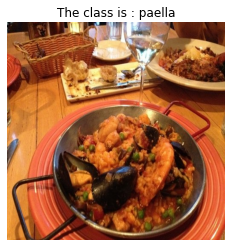

In [16]:
# Plotting an image tensor 
plt.imshow(image)
plt.title(f'The class is : {class_names[label.numpy()]}')
plt.axis(False) # turning off the axis

In [17]:
# What our image datatype? 
image.dtype

tf.uint8

`tf.uint8` format won't be the ideal for modelling. We gotta write a preprocess function which will conver the images from `tf.uint8` data type to `tf.float32`. 

This could ensure our data for modelling. 
Resizes the image to `(224 , 224)` and cast the datatype 

In [18]:
# Making a preprocess function (with resize)
def preprocess_img(image , label , img_shape = 224):
  '''
  Converts image datatypes from 'uint8' to 'float32' 
  Reshapes image to (img_shape , img_shape , color_channels)
  '''
  image = tf.image.resize(image , size = [img_shape , img_shape]) # reshapes to [224 , 224]
  return tf.cast(image , tf.float32) , label

Now let's test one of the images and labels with our preprocessed function 

In [19]:
# Checking the output of the preprocessed image and normal image
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[104 125 120]
  [ 99 118 114]
  [ 24  39  36]
  ...
  [113  49  24]
  [104  40  15]
  [114  50  25]]

 [[109 128 124]
  [111 130 126]
  [ 53  65  63]
  ...
  [112  48  23]
  [107  43  18]
  [113  49  24]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[106.89285   126.147964  122.02041  ]
  [  4.2397847  12.137743   11.040805 ]
  [ 10.076534   11.918371   15.637758 ]
  ...
  [107.305984   43.30598    16.305983 ]
  [116.99993    52.999935   27.999935 ]
  [108.581894   44.58189    19.581892 ]]

 [[119.13776   132.41837   130.0153   ]
  [ 24.5459     29.239777   29.964268 ]
  [ 15.612247   13.158165   16.285715 ]
  ...
  [110.13274    46.132732   19.132734 ]
  [109.137726   45.137726   18.137728 ]
  [107.03052    43.030518   16.030518 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


Awesome! Our functions work like a gem. 

Now we're going to map this function to all our images for both train and test data. 

Then will shuffle them and turn them into batches of size 64. 

In [20]:
# Map the preprocessing function to our training data (paralellize)
train_data = train_data.map(map_func= preprocess_img , num_parallel_calls= tf.data.AUTOTUNE)

# Shuffle train data and turn into batches and prefetch it (load the data faster)
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 64).prefetch(buffer_size = tf.data.AUTOTUNE)

# Mapping the preprocessing function on the test data 
test_data = test_data.map(map_func = preprocess_img , num_parallel_calls= tf.data.AUTOTUNE)

# Creating batches of our test data and enabling prefetch 
test_data = test_data.batch(batch_size= 64).prefetch(tf.data.AUTOTUNE) # Use the max processor for us

Great! We have done the preprocessing part, now let's look at the shapes of our train and test sets




In [21]:
# How does the resized train data looks like 
train_data , test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

We're going to enable the mixed precision for faster training

In [21]:
# Turn on mixed precision 
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy = 'mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


## Modelling Part 

We're going to build 3 types of models, 
- A VGG model.
- Transfer learning model 
- A pretrained model 

In [22]:
# Importing the needed packages 
from tensorflow.keras.layers import Input , Conv2D 
from tensorflow.keras.layers import MaxPool2D , Flatten , Dense 
from tensorflow.keras import Model

### VGG Model

In [118]:
# Building a VGG model 
inputs = Input(shape = (224 , 224 , 3))

# Conv Block 1 (64 filters)
x = Conv2D(filters= 64 , kernel_size= 3 , padding = 'same' , 
           activation = 'relu')(inputs)
x = Conv2D(64 , 3 , padding = 'same' , activation = 'relu')(x)
x = MaxPool2D(pool_size = 2 , strides= 2  , padding = 'same')(x)

# Conv Block 2 (128 filters)
x = Conv2D(128 , 3 , padding = 'same' , activation= 'relu')(x)
x = Conv2D(128 , 3 , padding = 'same' , activation = 'relu')(x)
x = MaxPool2D(pool_size = 2 , strides = 2 , padding ='same')(x)

# Conv Block 3 (256 filters)
x = Conv2D(256 , 3 , padding = 'same' , activation = 'relu')(x)
x = Conv2D(256 , 3 , padding = 'same' , activation = 'relu')(x)
x = Conv2D(256 , 3 , padding = 'same' , activation = 'relu')(x)
x = MaxPool2D(pool_size =2  , strides = 2 , padding ='same')(x)

# 4th Conv block

x = Conv2D(filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D(filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D(filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 5th Conv block

x = Conv2D(filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D(filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D(filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# Constructing a Dense layer (3 fully connected layers)
x = Flatten()(x)
x = Dense(4096 , activation= 'relu')(x)
x = Dense(4096 , activation= 'relu')(x)
x = Dense(len(class_names))(x)

# Output layer 
outputs = tf.keras.layers.Activation('softmax' , dtype = tf.float32 , 
                                     name = 'output_layer')(x)

# Packing everything into a model 
vgg_model = Model(inputs , outputs)

# Checking the summary of the model 
vgg_model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 56, 56, 128)       0   

In [125]:
# Compiling our model 
vgg_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
                  optimizer = tf.keras.optimizers.Adam() , 
                  metrics = ['accuracy'])

# Fitting the model 
vgg_history = vgg_model.fit(train_data , 
                            epochs = 6 ,
                            steps_per_epoch = len(train_data) , 
                            validation_data = test_data , 
                            validation_steps = int(0.2 * len(test_data)))

Epoch 1/6
1184/1184 [==============================] - 599s 503ms/step - loss: 4.6155 - accuracy: 0.0088 - val_loss: 4.6149 - val_accuracy: 0.0103
Epoch 2/6
1184/1184 [==============================] - 595s 501ms/step - loss: 4.6155 - accuracy: 0.0093 - val_loss: 4.6150 - val_accuracy: 0.0113
Epoch 3/6
1184/1184 [==============================] - 595s 501ms/step - loss: 4.6155 - accuracy: 0.0093 - val_loss: 4.6149 - val_accuracy: 0.0111
Epoch 4/6
1184/1184 [==============================] - 595s 501ms/step - loss: 4.6155 - accuracy: 0.0096 - val_loss: 4.6149 - val_accuracy: 0.0113
Epoch 5/6
1184/1184 [==============================] - 596s 502ms/step - loss: 4.6155 - accuracy: 0.0091 - val_loss: 4.6149 - val_accuracy: 0.0113
Epoch 6/6
1184/1184 [==============================] - 596s 502ms/step - loss: 4.6155 - accuracy: 0.0095 - val_loss: 4.6149 - val_accuracy: 0.0113


In [126]:
vgg_model_result = vgg_model.evaluate(test_data)

395/395 [==============================] - 65s 164ms/step - loss: 4.6151 - accuracy: 0.0099


That was such a bad performance by our VGG model, which we built from scracth. 

This is expected before, now it's time to create some callbacks and jump into Transfer Learning. 

### Callbacks 
We're going to use some important callbacks for our model. Even get to know the callbacks which I didn't came across, this is gonna be fun. 

The callbacks we're going to work with are: 
- ModelCheckpoint Callback
- LearningRateScheduler Callback 
- EarlyStopping Callback 
- ReduceLRPlateau Callback 

I will link the resources in here which helped me in learning these callbacks. 

In [26]:
# Import all the callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping , ReduceLROnPlateau , LearningRateScheduler

Alright we will be creating two types of callbacks. One is for the Transfer Learning models and the other is for the pre-trained model. 


In [27]:
# Creating the ModelCheckpoint Callback for our transfer learning models 


# For the EfficientNet_B0 Model
checkpoint_filepath_efficientnet_b0 = 'checkpoint_efficientnet_b0_weights/checkpoint.ckpt'

# Creating a ModelCheckpoint Callback that saves the weights only 
checkpoint_efficientnet_b0 = ModelCheckpoint(filepath = checkpoint_filepath_efficientnet_b0 , 
                                             save_weights = True , 
                                             save_best_only = False , # We need all the weights not just the best weights
                                             save_freq = 'epoch' , # Every epoch
                                             verbose = 1)

# For the EfficientNet_B3 Model 
checkpoint_filepath_efficientnet_b3 = 'checkpoint_efficientnet_b3_weights/checkpoint.ckpt'

checkpoint_efficientnet_b3 = ModelCheckpoint(filepath = checkpoint_filepath_efficientnet_b3,
                                             save_weights = True , 
                                             save_best_only = False , 
                                             save_freq = 'epoch' , 
                                             verbose = 1)

# For the Resnet_v2_50 model 
checkpoint_filepath_resnet = 'checkpoint_resnet_weights/checkpoint.ckpt'

checkpoint_resnet = ModelCheckpoint(filepath = checkpoint_filepath_resnet , 
                                    save_weights = True , 
                                    save_best_only = False , 
                                    save_freq = 'epoch' , 
                                    verbose = 1)

Before jumping into other callbacks let's build a transfer learning model more like a base line for fewer epochs and observe the performance. 

Now we're gonna build 3 models, 
- EfficientNet_B0
- EfficientNet_B3
- Resnet_V2_50


In [28]:
# All the model URLS in here 
import tensorflow_hub as hub

resnet_50_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'
efficientnet_b0_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'
efficientnet_b3_url = 'https://tfhub.dev/google/efficientnet/b3/feature-vector/1'

Let's create a function which helps us to create the transfer learning model.

In [ ]:
def create_model(model_url , num_classes , augmentation = False , is_efficientnet=True ):
  '''
  Takes a TensorFlow Hub URL and creates a keras Sequential Model with it

  Returns: 
    An uncompiled Keras Sequential Model with the model_url as feature extraction
    layer and Dense output layer with num_classes depends on our problem.
  '''

  # Download the feature vector model and save it as a Keras layer 
  feature_extractor_layer = hub.KerasLayer(model_url , 
                                           trainable = False , 
                                           name = 'feature_extraction_layer')
  
  if is_efficientnet == 'True':
    if augmentation == 'False':
      inputs = Input(shape = (224 , 224 , 3) , name = 'Input_layer')(feature_extractor_layer)
      x = data_augmentation(inputs)
      x = layers.Dense(len(class_names))(x)
      outputs = layers.Dense(activation = 'softmax' , dtype = tf.float32 , name = 'output_layer')
      
      
  

  if augmentation == 'False':
     # Create our model by replacing the last layers 
     model = tf.keras.Sequential([
        feature_etxtractor_layer , 
        tf.keras.layers.Dense(len(class_names)) , 
        tf.keras.layers.Dense(activation='softmax' , dtype = tf.float32 , 'output_layer')
        ])
 

In [30]:
def create_model(model_url , num_classes):
  '''
  Takes a TensorFlow Hub URL and creates a keras Sequential Model with it

  Returns: 
    An uncompiled Keras Sequential Model with the model_url as feature extraction
    layer and Dense output layer with num_classes depends on our problem.
  '''
  IMG_SIZE = (224 , 224)

  # Download the feature vector model and save it as a Keras layer 
  feature_extractor_layer = hub.KerasLayer(model_url , 
                                           trainable = False , 
                                           name = 'feature_extraction_layer' , 
                                           input_shape = IMG_SIZE + (3,))
  # 
  
  model = tf.keras.Sequential([
      feature_extractor_layer , 
      tf.keras.layers.Dense(num_classes , activation = 'softmax')
      #tf.keras.layers.Activation('softmax' , dtype = tf.float32 , name='output_layer')
    ])

     
  return model

In [31]:
efficientnet_b0_model = create_model(efficientnet_b0_url , num_classes= len(class_names))

# Compiling the model 
efficientnet_b0_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                              optimizer = tf.keras.optimizers.Adam() , 
                              metrics = ['accuracy'])


In [32]:
efficientnet_b0_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
Total params: 4,178,945
Trainable params: 129,381
Non-trainable params: 4,049,564
_________________________________________________________________


In [33]:
history_fine_tune_efficient_b0 = efficientnet_b0_model.fit(train_data , 
                                                           steps_per_epoch = len(train_data) , 
                                                           validation_data = test_data , 
                                                           validation_steps = int(0.2 * len(test_data)) , 
                                                            epochs = 10 , 
                                                           callbacks = [checkpoint_efficientnet_b0])

Epoch 1/10
1184/1184 [==============================] - 235s 165ms/step - loss: 1126.1080 - accuracy: 0.0116 - val_loss: 1021.3809 - val_accuracy: 0.0123

Epoch 00001: saving model to checkpoint_efficientnet_b0_weights/checkpoint.ckpt
INFO:tensorflow:Assets written to: checkpoint_efficientnet_b0_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: checkpoint_efficientnet_b0_weights/checkpoint.ckpt/assets


Epoch 2/10
1184/1184 [==============================] - 168s 141ms/step - loss: 877.5936 - accuracy: 0.0167 - val_loss: 1075.3534 - val_accuracy: 0.0119

Epoch 00002: saving model to checkpoint_efficientnet_b0_weights/checkpoint.ckpt
INFO:tensorflow:Assets written to: checkpoint_efficientnet_b0_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: checkpoint_efficientnet_b0_weights/checkpoint.ckpt/assets


Epoch 3/10
1184/1184 [==============================] - 175s 142ms/step - loss: 820.0186 - accuracy: 0.0200 - val_loss: 983.8801 - val_accuracy: 0.0131

Epoch 00003: saving model to checkpoint_efficientnet_b0_weights/checkpoint.ckpt
INFO:tensorflow:Assets written to: checkpoint_efficientnet_b0_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: checkpoint_efficientnet_b0_weights/checkpoint.ckpt/assets


Epoch 4/10
1184/1184 [==============================] - 155s 129ms/step - loss: 788.8232 - accuracy: 0.0231 - val_loss: 964.6432 - val_accuracy: 0.0170

Epoch 00004: saving model to checkpoint_efficientnet_b0_weights/checkpoint.ckpt
INFO:tensorflow:Assets written to: checkpoint_efficientnet_b0_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: checkpoint_efficientnet_b0_weights/checkpoint.ckpt/assets


Epoch 5/10
1184/1184 [==============================] - 156s 130ms/step - loss: 771.4250 - accuracy: 0.0269 - val_loss: 998.8010 - val_accuracy: 0.0142

Epoch 00005: saving model to checkpoint_efficientnet_b0_weights/checkpoint.ckpt
INFO:tensorflow:Assets written to: checkpoint_efficientnet_b0_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: checkpoint_efficientnet_b0_weights/checkpoint.ckpt/assets


Epoch 6/10
1184/1184 [==============================] - 155s 129ms/step - loss: 746.4275 - accuracy: 0.0278 - val_loss: 963.2420 - val_accuracy: 0.0123

Epoch 00006: saving model to checkpoint_efficientnet_b0_weights/checkpoint.ckpt
INFO:tensorflow:Assets written to: checkpoint_efficientnet_b0_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: checkpoint_efficientnet_b0_weights/checkpoint.ckpt/assets


Epoch 7/10
1184/1184 [==============================] - 155s 129ms/step - loss: 737.5832 - accuracy: 0.0303 - val_loss: 1060.3070 - val_accuracy: 0.0121

Epoch 00007: saving model to checkpoint_efficientnet_b0_weights/checkpoint.ckpt
INFO:tensorflow:Assets written to: checkpoint_efficientnet_b0_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: checkpoint_efficientnet_b0_weights/checkpoint.ckpt/assets


Epoch 8/10
1184/1184 [==============================] - 155s 130ms/step - loss: 754.5711 - accuracy: 0.0328 - val_loss: 1059.3138 - val_accuracy: 0.0123

Epoch 00008: saving model to checkpoint_efficientnet_b0_weights/checkpoint.ckpt
INFO:tensorflow:Assets written to: checkpoint_efficientnet_b0_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: checkpoint_efficientnet_b0_weights/checkpoint.ckpt/assets


Epoch 9/10
1184/1184 [==============================] - 155s 130ms/step - loss: 718.3531 - accuracy: 0.0324 - val_loss: 1080.5465 - val_accuracy: 0.0131

Epoch 00009: saving model to checkpoint_efficientnet_b0_weights/checkpoint.ckpt
INFO:tensorflow:Assets written to: checkpoint_efficientnet_b0_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: checkpoint_efficientnet_b0_weights/checkpoint.ckpt/assets


Epoch 10/10
1184/1184 [==============================] - 155s 130ms/step - loss: 722.3339 - accuracy: 0.0340 - val_loss: 1134.7032 - val_accuracy: 0.0133

Epoch 00010: saving model to checkpoint_efficientnet_b0_weights/checkpoint.ckpt
INFO:tensorflow:Assets written to: checkpoint_efficientnet_b0_weights/checkpoint.ckpt/assets


INFO:tensorflow:Assets written to: checkpoint_efficientnet_b0_weights/checkpoint.ckpt/assets


In [34]:
# Evaluating on the whole test data 

efficientnet_b0_model_tl = efficientnet_b0_model.evaluate(test_data)

395/395 [==============================] - 52s 131ms/step - loss: 1052.2356 - accuracy: 0.0143


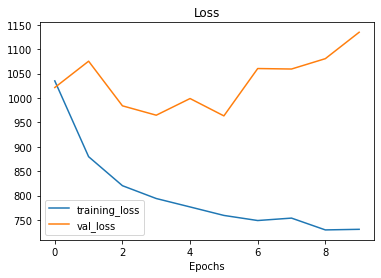

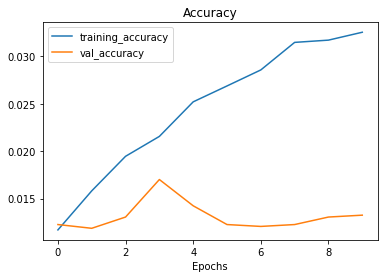

In [39]:
# Let's plot a loss curves
plot_loss_curves(history_fine_tune_efficient_b0)

Eww.. Transfer learning model seems to perform worse. Maybe it's time to move on with pretrained models and fine-tuning them. Looking at this performance I have no hope neither efficientnet_b3 (or) resnet_v2_50 would do any better. 

##

In [45]:
print('Hello World')

Hello World


Next thing we're gonna do is create two types of models. 
- With Augmentation 
- Without Augmentation 

These models will contain two callbacks at first one will be `EarlyStopping` and the other is `ModelCheckpoint` callbacks. Depends on the results we'll integrate other two callbacks to improve our results further. 

In [47]:
# Building a augmentation Sequential layer 
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Input , Dense , Activation

data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip('horizontal') , 
  preprocessing.RandomWidth(0.2) ,
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2)
])

# For the Resnet Model 
data_augmentation_resnet = tf.keras.Sequential([
  preprocessing.Rescaling(1./255)
  preprocessing.RandomFlip('horizontal') , 
  preprocessing.RandomWidth(0.2) ,
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2)
])

SyntaxError: ignored